In [3]:
from matplotlib.pyplot import bar
import matplotlib.pyplot as plt
import numpy as np
import json
import colorlover as cl
from IPython.display import HTML
from IPython.display import Markdown
import scipy
from scipy import stats
import networkx as nx

In [4]:
import seaborn as sns
#plt.style.use('default')
plt.style.use('seaborn')

# Read corpus

In [5]:
def gen_token(n_line=-1):
    with open("./res.json") as f:
        text = [ json.loads(l) for l in f.readlines() ]

    if n_line != -1:
        line = " ".join(text[n_line]["text"])
        for t in text[n_line]["tokens"]:
            yield t["token"], t["pos"], t["dep"], t["gates"], t["attention"], line
        return

    for l in text:
        line = " ".join(l["text"])
        for t in l["tokens"]:
            yield t["token"], t["pos"], t["dep"], t["gates"], t["attention"], line

# Count tokens

In [6]:
def get_count():
    count_pos, count_dep, count_mixed = {}, {}, {}
    count_pos_layer, count_dep_layer, count_mixed_layer = {}, {}, {}
    for token, pos, dep, gates, att, line in gen_token():
        sum_gates = [sum(gates)]
        sum_gates_layer = [np.array(gates).reshape(12, 12).sum(axis=1)]

        if pos not in count_pos:
            count_pos[pos] = []
            count_pos_layer[pos] = []
        if dep not in count_dep:
            count_dep[dep] = []
            count_dep_layer[dep] = []
        if (pos, dep) not in count_mixed:
            count_mixed[(pos, dep)] = []
            count_mixed_layer[(pos, dep)] = []

        count_dep[dep] += sum_gates
        count_dep_layer[dep] += sum_gates_layer

        count_pos[pos] += sum_gates
        count_pos_layer[pos] += sum_gates_layer

        count_mixed[(pos, dep)] += sum_gates
        count_mixed_layer[(pos, dep)] += sum_gates_layer

    return (count_pos, count_dep, count_mixed,
            count_pos_layer, count_dep_layer, count_mixed_layer)

count_pos, count_dep, count_mixed, count_pos_layer, count_dep_layer, count_mixed_layer = get_count()

In [7]:
def explore_sub(fct, key):
    count = {}
    for token, pos, dep, gates, att, line in gen_token():
        if fct(pos, dep) == key:
            if fct(dep, pos) not in count:
                count[fct(dep, pos)] = []
            count[fct(dep, pos)] += [sum(gates)]
    return count

# tableau: moyenne, écart standard

In [ ]:
sort = lambda z : sorted(z, key=lambda x: -np.mean(z[x]))

In [ ]:
print ("{:<10}{:<10}{:<10}{:<10}{}".format("POS", "Freq", "Mean", "Std Dev", "Non zero %\n"))
print ("mean", np.array([ e for c in count_pos for e in count_pos[c] ]).mean())

for k in sort(count_pos):
    if len(count_pos[k]) > 10:
        print ("{:<10}{:<10}{:<10}{}".format(k,
                                             len(count_pos[k]),
                                             round(np.mean(count_pos[k]), 2),
                                             round(np.std(count_pos[k])), 2))

In [ ]:
print ("{:<15}{:<10}{:<10}{}".format("POS", "Freq", "Mean", "Std Dev\n"))

for k in sort(count_mixed):
    if len(count_mixed[k]) > 5:
        print ("{:<15}{:<10}{:<10}{}".format("-".join(k),
                                             len(count_mixed[k]),
                                             round(np.mean(count_mixed[k]), 2),
                                             round(np.std(count_mixed[k]), 2)))

In [ ]:
k = "VERB"
print ("\n{:<15}{:<10}{}".format(k, len(count_pos[k]), np.mean(count_pos[k])))
count = explore_sub(lambda pos, dep: pos, "VERB")
for n in sort(count):
    if len(count[n]) <= 10:
        continue
    print ("{:<15}{:<15}{:<10}{:<10}{}".format("",
                                               n,
                                               len(count[n]),
                                               round(np.mean(count[n]), 2),
                                               round(np.std(count[n])), 2))

In [ ]:
print ("{:<15}{:<15}{:<10}{:<10}{}".format("POS", "DEP", "Freq", "Mean", "Std Dev\n"))

for k in sort(count_pos):
    if len(count_pos[k]) > 5:
        print ("\n{:<15}{:<10}{}".format(k, len(count_pos[k]), np.mean(count_pos[k])))
        count = explore_sub(lambda pos, dep: pos, k)
        for n in sort(count):
            if len(count[n]) > 10:
                print ("{:<15}{:<15}{:<10}{:<10}{}".format("",
                                                           n,
                                                           len(count[n]),
                                                           round(np.mean(count[n]), 2),
                                                           round(np.std(count[n])), 2))

# Layer par layer

In [11]:
norm = lambda x: x / np.sum(x)
slice_mean = lambda x, n: x.reshape(int(12/n), n).mean(axis=1)
layer_mean = lambda x: np.array(x).mean(axis=0)

In [8]:
def sort_layer(n_layer):
    sort = lambda z : sorted(z, key=lambda x: -np.mean(np.array(z[x])[:,n_layer]))

    print ("{:<10}{:<10}{:<10}{}".format("POS", "Freq", "Mean", "Std Dev\n"))
    for k in sort(count_pos_layer):
        layer_gates = np.array(count_pos_layer[k])[:,n_layer]
        if len(layer_gates) > 10:
            print ("{:<10}{:<10}{:<10}{}".format(k,
                                             len(layer_gates),
                                             round(layer_gates.mean(), 4),
                                             round(np.std(layer_gates), 4)))

In [9]:
for i in range(12):
    print ("layer", i+1)
    sort_layer(i)
    print ()

layer 1
POS       Freq      Mean      Std Dev

NOUN      2107      0.3888    0.5506
PROPN     1106      0.3693    0.64
ADJ       741       0.3635    0.6122
NUM       278       0.3377    0.4994
VERB      1880      0.2765    0.4346
PART      241       0.2763    0.3572
ADV       471       0.2719    0.5275
PRON      335       0.2549    0.5451
CCONJ     261       0.2289    0.5267
ADP       1461      0.2126    0.4019
DET       1284      0.1943    0.4309
PUNCT     1151      0.1918    0.3095
SYM       15        0.0539    0.0995

layer 2
POS       Freq      Mean      Std Dev

ADJ       741       0.8182    0.7166
NOUN      2107      0.7826    0.5648
PRON      335       0.7499    0.6643
VERB      1880      0.7464    0.5072
PROPN     1106      0.7086    0.5984
ADV       471       0.7074    0.5958
PUNCT     1151      0.6825    0.4389
NUM       278       0.6788    0.4939
CCONJ     261       0.5806    0.6153
PART      241       0.5675    0.421
DET       1284      0.5615    0.532
ADP       1461      0

In [17]:
coeff = [ (k, np.corrcoef(np.arange(12), layer_mean(count_pos_layer[k]))[0][1]) for k in count_pos_layer ]
for k, val in sorted(coeff, key=lambda x: -x[1]):
    if len(count_pos_layer[k]) > 10:
        print ("{:<10}{}".format(k, val))

PROPN     0.6292304264773222
NUM       0.5897757961568119
NOUN      0.5824119631718839
ADJ       0.494657598114845
VERB      0.2332836027496776
ADV       0.02854894020769136
PRON      -0.002923322481038382
CCONJ     -0.274459858825436
ADP       -0.2769572975746338
DET       -0.3707183271922657
SYM       -0.37931397037018705
PUNCT     -0.6712061944879472
PART      -0.80233540492066


In [19]:
def explore_verb():
    count = {}
    for token, pos, dep, gates, att, line in gen_token():
        sum_gates_layer = [np.array(gates).reshape(12, 12).sum(axis=1)]
        if pos == "VERB":
            if dep not in count:
                count[dep] = []
            count[dep] += sum_gates_layer
    return count
count_verb = explore_verb()

coeff = [ (k, np.corrcoef(np.arange(12), layer_mean(count_verb[k]))[0][1]) for k in count_verb ]

coeff = sorted(coeff, key=lambda x: -x[1])
for k, val in coeff:
    if len(count_verb[k]) > 10:
        print ("{:<10}{}".format(k, val))

advcl     0.5867030944025193
amod      0.5101399811064419
acl       0.4268681287745828
pcomp     0.414140307432665
conj      0.3437237286991277
xcomp     0.31366038597624385
ccomp     0.26306725317994595
ROOT      0.25771626935962655
relcl     0.22759423575273713
prep      -0.04236129262061096
aux       -0.13572831762187956
auxpass   -0.5358505915731697


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

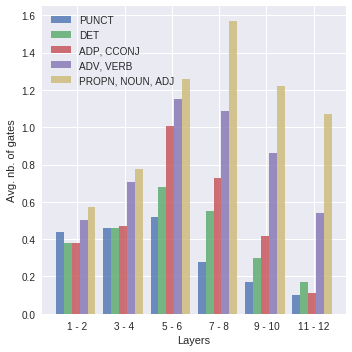

In [21]:
merge = [["PROPN", "NOUN", "ADJ"], ["ADV", "VERB"], ["ADP"], ["DET"], ["PUNCT"] ]
merge = [["PUNCT"], ["DET"], ["ADP", "CCONJ"], ["ADV", "VERB"], ["PROPN", "NOUN", "ADJ"]]

fig, ax = plt.subplots(figsize=(5, 5))
index = np.arange(6)
bar_width = 1/6
opacity = 0.8

for i, k in enumerate(merge):

    val = np.array([ slice_mean(layer_mean(count_pos_layer[e]), 2) for e in k ]).mean(axis=0)
    plt.bar(index + bar_width * i, val, bar_width, alpha=opacity, label=", ".join(k))


plt.xlabel('Layers')
plt.ylabel('Avg. nb. of gates')

plt.xticks(index + bar_width + .2, [ str((i+1)*2-1) + " - " + str((i+1)*2) for i in np.arange(12)])
plt.legend()

plt.tight_layout()
plt.savefig("9.eps", method=".eps")
plt.show()

### Measure of entropy POS

In [ ]:
def get_ent(att):
    return np.array([ 0 if head_att == 0 else scipy.stats.entropy(head_att) for layer_att in att for head_att in layer_att ])

def get_ent_pos():
    count_ent_pos = {}
    for token, pos, dep, gates, att, line in gen_token():
        if pos not in count_ent_pos:
            count_ent_pos[pos] = []
        count_ent_pos[pos] += [get_ent(att)]
    return count_ent_pos

count_ent_pos = get_ent_pos()

In [22]:
sort = lambda z : sorted(z, key=lambda x: -np.mean(z[x]))
for k in sort(count_ent_pos):
    if len(count_ent_pos[k]) > 10:
        
        print ("POS: {:<10} mean: {:<10}".format(k, np.mean(count_ent_pos[k])))
        x = np.array([ [i]*12 for i in range(12) ]).flatten()
        ent = np.array(count_ent_pos[k]).mean(0)
    
        #plt.scatter(x, ent)
        #plt.plot(ent.reshape(12, 12).mean(1))
        #plt.show()

NameError: name 'count_ent_pos' is not defined

In [23]:
glob_ent = []
for token, pos, dep, gates, att, line in gen_token():
    glob_ent += [get_ent(att)]
glob_ent = np.array(glob_ent).mean(0)
x = np.array([ [i]*12 for i in range(12) ]).flatten()
ent = np.array(glob_ent)
plt.scatter(x, ent)
plt.plot(ent.reshape(12, 12).mean(1))
plt.show()

NameError: name 'get_ent' is not defined

In [87]:
color_scales = cl.scales['11']["div"]["Spectral"]
span = lambda x, c: "<span style=\"color:" + c + "\">" + x + "</span>"
bin_rgb = lambda x: str(color_scales[10 - int(x / (5/11))])
print_mkdw = lambda x: display (Markdown(x))

def print_att(att):
    plt.imshow(att)
    plt.yticks([])
    plt.show()
    plt.figure(figsize = (20,2))
    plt.yticks([])
    plt.imshow([att.sum(0)])
    plt.show()

def print_att_token(line, flat_att, token):
    res = []
    for l, a in zip(line.split(" "), flat_att):
        a = np.log2(a+1)
        if l == token:
            res += [span("(*" + l + "*)", bin_rgb(a))]
            #res += [ '<span style="color: red">' + l + '</span>' ]
        elif a > 0.:
            res += [span(l, bin_rgb(a))]
        else:
            res += [l]
    return  "### " + " ".join(res)

In [88]:
for i, (token, pos, dep, gates, att, line) in enumerate(gen_token(53)):
    #print ("\n\n\n{:<5}{:<20}{:<20}{}".format(0, token, pos, dep))
    att = stack_att(att)
    flat_att = att.sum(0)
    #print (att.shape)
    #print_att(att)
    #print_mkdw( print_att_token(line, flat_att, token) )

In [ ]:
att_line, line, lab = get_stack_att_line(n_line=68, start_layer=-1, end_layer=6, norm=False)
print_mat_att(att_line[1:,1:-1], line[1:-1], lab[1:])

### Schemas 1

In [63]:
def value_gates():
    gate_val = []
    for token, pos, dep, gates, att, line in gen_token():
        gate_val += [np.array(gates)]
    return np.array(gate_val)
gate_values = value_gates()

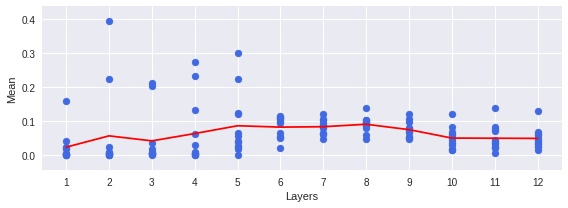

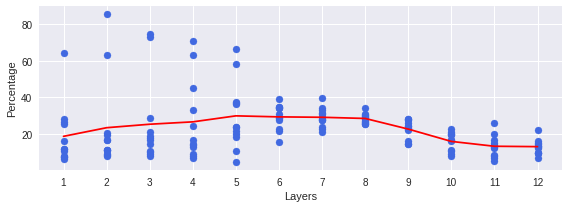

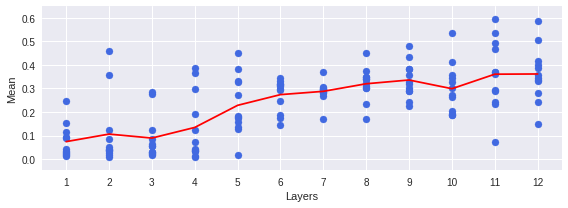

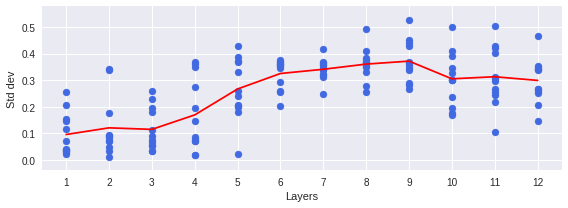

In [64]:
size = (8, 3)

x_ticks = list(range(1, 13))
x = np.array([ [i+1]*12 for i in range(12) ]).flatten()

plt.figure(figsize=size)
plt.scatter(x, gate_values.mean(0), c="royalblue")
plt.plot(x_ticks, gate_values.reshape(-1, 12, 12).mean(0).mean(1), c="red")
plt.xlabel("Layers")
plt.ylabel("Mean")
plt.xticks(x_ticks)

plt.tight_layout()
plt.savefig("1.eps", method=".eps")
plt.show()

plt.figure(figsize=size)
pnz = np.array([ e != 0 for e in gate_values ]).mean(0)
plt.scatter(x, pnz*100, c="royalblue")
plt.plot(x_ticks, pnz.reshape(-1, 12, 12).mean(0).mean(1)*100, c="red")
plt.xlabel("Layers")
plt.ylabel("Percentage")
plt.xticks(x_ticks)

plt.tight_layout()
plt.savefig("2.eps", method=".eps")
plt.show()


plt.figure(figsize=size)
nz = np.array([ e[e != 0].mean() for e in gate_values.transpose() ])
plt.scatter(x, nz, c="royalblue")
plt.plot(x_ticks, nz.reshape(-1, 12, 12).mean(0).mean(1), c="red")
plt.xlabel("Layers")
plt.ylabel("Mean")
plt.xticks(x_ticks)

plt.tight_layout()
plt.savefig("3.eps", method=".eps")
plt.show()

plt.figure(figsize=size)
st = np.std(gate_values.transpose(), 1)
plt.scatter(x, st, c="royalblue")
plt.plot(x_ticks, st.reshape(-1, 12, 12).mean(0).mean(1), c="red")
plt.xlabel("Layers")
plt.ylabel("Std dev")
plt.xticks(x_ticks)

plt.tight_layout()
plt.savefig("4.eps", method=".eps")
plt.show()

* ## Schemas 2

In [66]:
# distance attention

def get_idx_word_line(prev_line, line, voc_word_line):
    # get word index in current line
    if prev_line != line:
        voc_word_line = {}
        prev_line = line
    
    list_idx = [ i for i, e in enumerate(line.split(" ")) if e == token ]
    
    if token not in voc_word_line:
        voc_word_line[token] = 1
    else:
        voc_word_line[token] += 1
    
    return list_idx[voc_word_line[token]-1], prev_line, voc_word_line

prev_line, voc_word_line = "", {}
dist_att = [[] for _ in range(12*12)]
for token, pos, dep, gates, att, line in gen_token():
    
    idx, prev_line, voc_word_line = get_idx_word_line(prev_line, line, voc_word_line)

    # iter on attention
    for i, a in enumerate([z for e in att for z in e]):
        if a != 0:
            # get most attended token
            s = np.argmax(a)
            dist_att[i] += [abs(s - idx)]

In [68]:
# entropy mean

entropy_gates = [[] for _ in range(12*12)]
for token, pos, dep, gates, att, line in gen_token():
    
    # iter on attention
    for i, a in enumerate([z for e in att for z in e]):
        if a != 0:
            entropy_gates[i] += [scipy.stats.entropy(a)]

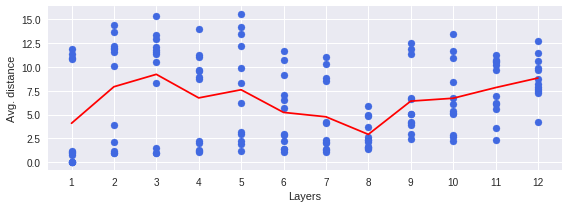

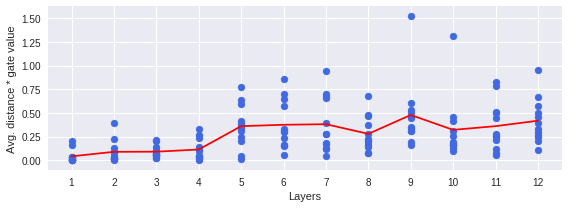

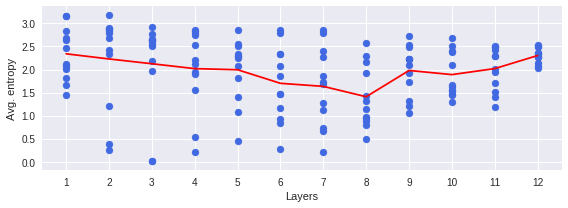

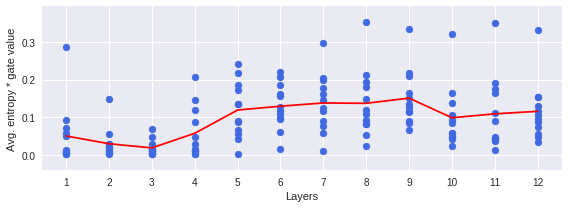

In [69]:
x_ticks = list(range(1, 13))
x = np.array([ [i+1]*12 for i in range(12) ]).flatten()

plt.figure(figsize=size)
dm = np.array([ np.mean(e) for e in dist_att ])
plt.scatter(x, dm, c="royalblue")
plt.plot(x_ticks, dm.reshape(-1, 12, 12).mean(0).mean(1), c="red")
plt.xlabel("Layers")
plt.ylabel("Avg. distance")
plt.xticks(x_ticks)

plt.tight_layout()
plt.savefig("5.eps", method=".eps")
plt.show()

plt.figure(figsize=size)
plt.scatter(x, dm * gate_values.mean(0), c="royalblue")
plt.plot(x_ticks, (dm * gate_values.mean(0)).reshape(-1, 12, 12).mean(0).mean(1), c="red")
plt.xlabel("Layers")
plt.ylabel("Avg. distance * gate value")
plt.xticks(x_ticks)

plt.tight_layout()
plt.savefig("6.eps", method=".eps")
plt.show()

plt.figure(figsize=size)
em = np.array([ np.mean(e) for e in entropy_gates ])
plt.scatter(x, em, c="royalblue")
plt.plot(x_ticks, em.reshape(-1, 12, 12).mean(0).mean(1), c="red")
plt.xlabel("Layers")
plt.ylabel("Avg. entropy")
plt.xticks(x_ticks)

plt.tight_layout()
plt.savefig("7.eps", method=".eps")
plt.show()

plt.figure(figsize=size)
plt.scatter(x, em * gate_values.mean(0), c="royalblue")
plt.plot(x_ticks, (em * gate_values.mean(0)).reshape(-1, 12, 12).mean(0).mean(1), c="red")
plt.xlabel("Layers")
plt.ylabel("Avg. entropy * gate value")
plt.xticks(x_ticks)

plt.tight_layout()
plt.savefig("8.eps", method=".eps")
plt.show()

### explain case of gate 13 and other gates

In [70]:
# gate 13
# low zero values, low distance attention, low entropy
# gate 100
# low zero values, low distance attention, high entropy

In [71]:
def explore_gate(n_gate):
    print ("\t\tGlob\t\tGate", n_gate)
    mean_gates = gate_values.mean(0)
    print ("Mean value:\t{}\t\t{}".format(round(mean_gates.mean(0), 4),
                                            round(mean_gates[n_gate], 4)))
    print ("non zero %:\t{}\t\t{}".format(round(pnz.mean(0), 4),
                                          round(pnz[n_gate], 4)))
    print ("Mean distance:\t{}\t\t{}".format(round(dm.mean(0), 4),
                                             round(dm[n_gate], 4)))
    print ("Mean entropy:\t{}\t\t{}".format(round(em.mean(0), 4),
                                            round(em[n_gate], 4)))

In [72]:
explore_gate(n_gate=13)

		Glob		Gate 13
Mean value:	0.063		0.3938
non zero %:	0.2287		0.8576
Mean distance:	6.5225		1.0019
Mean entropy:	1.971		0.3764


In [73]:
explore_gate(n_gate=20)

		Glob		Gate 20
Mean value:	0.063		0.0021
non zero %:	0.2287		0.1095
Mean distance:	6.5225		10.128
Mean entropy:	1.971		2.873


In [74]:
explore_gate(n_gate=131)

		Glob		Gate 131
Mean value:	0.063		0.0727
non zero %:	0.2287		0.2012
Mean distance:	6.5225		6.1091
Mean entropy:	1.971		2.4132


### By string name

In [75]:
def next_word(sentence, words, size_line, token, i):
    while words[i] != token:
        sentence += [ ("UNK", "UNK", np.zeros((12, size_line))) ]    
        i += 1
    return sentence, i + 1

corpus = []
prev_line = ""
for token, pos, dep, gates, att, line in gen_token():

    if prev_line != line:
        if prev_line != "":
            sentence += [("UNK", "SEP", np.zeros((12, size_line)))]    
            corpus += [sentence]
        i = 1
        words = line.split(" ")
        size_line = len(words)
        prev_line = line
        sentence = [("UNK", "CLS", np.zeros((12, size_line)))]    

    sentence, i = next_word(sentence, words, size_line, token, i)
    att_layer = np.array([ np.sum([ np.zeros(size_line) if not e else e for e in l_a ], 0) for l_a in att ])

    sentence += [(token, pos, att_layer)]

In [76]:
count = {}
count_punct = {}
count_coord = {}
count_adp = {}
count_layer = {}
for sentence in corpus:
    
    att = np.array([ att for token, pos, att in sentence ])
    toks = np.array([ token for token, pos, att in sentence ])
    pos = np.array([ pos for token, pos, att in sentence ])
    att = att.transpose(1, 0, 2).sum(1)

    for i in range(len(pos)):
        
        if pos[i] not in count:
            count[pos[i]] = []
            count_layer[pos[i]] = []
        if pos[i] == "PUNCT" and toks[i] not in count_punct:
            count_punct[toks[i]] = []
        if pos[i] == "CCONJ" and toks[i] not in count_coord:
            count_coord[toks[i]] = []
        if pos[i] == "ADP" and toks[i] not in count_adp:
            count_adp[toks[i]] = []

        if pos[i] == "PUNCT":
            count_punct[toks[i]] += [att.sum(0)[i]]
        if pos[i] == "CCONJ":
            count_coord[toks[i]] += [att.sum(0)[i]]
        if pos[i] == "ADP":
            count_adp[toks[i]] += [att.sum(0)[i]]

        count[pos[i]] += [att.sum(0)[i]]
        count_layer[pos[i]] += [att[:,i]]

In [77]:
for k in sort(count_coord):
    if len(count_coord[k]) > 5:
        print ("{:<10}{:<10}{:<10}{}".format(k,
                                             len(count_coord[k]),
                                             round(np.mean(count_coord[k]), 2),
                                             round(np.std(count_coord[k])), 2))

but       37        10.76     5.0
or        9         9.44      4.0
and       214       8.96      5.0


In [78]:
for k in sort(count_punct):
    if len(count_punct[k]) > 5:
        print ("{:<10}{:<10}{:<10}{}".format(k,
                                             len(count_punct[k]),
                                             round(np.mean(count_punct[k]), 2),
                                             round(np.std(count_punct[k])), 2))

.         503       14.64     9.0
"         92        11.84     5.0
,         439       10.91     6.0
-         102       6.7       5.0


## Received attention

In [79]:
print ("{:<10}{:<10}{:<10}{:<10}{}".format("POS", "Freq", "Mean", "Std Dev", "Non zero %\n"))
print ("mean", np.array([ e for c in count for e in count[c] ]).mean())

for k in sort(count):
    if len(count[k]) > 10:
        print ("{:<10}{:<10}{:<10}{}".format(k,
                                             len(count[k]),
                                             round(np.mean(count[k]), 2),
                                             round(np.std(count[k])), 2))

POS       Freq      Mean      Std Dev   Non zero %

mean 11.219684574156469
SEP       529       27.59     16.0
NOUN      2103      12.42     7.0
PUNCT     1150      12.25     8.0
VERB      1879      11.71     6.0
PROPN     1105      11.07     6.0
ADP       1455      10.51     6.0
ADJ       741       10.15     5.0
ADV       470       10.15     6.0
UNK       707       9.69      6.0
NUM       276       9.54      5.0
CCONJ     261       9.24      5.0
PRON      335       8.96      6.0
DET       1283      8.13      4.0
SYM       15        8.03      3.0
PART      241       7.72      4.0
CLS       529       5.3       3.0


In [80]:
def sort_layer(n_layer):
    sort = lambda z : sorted(z, key=lambda x: -np.mean(np.array(z[x])[:,n_layer]))

    print ("{:<10}{:<10}{:<10}{}".format("POS", "Freq", "Mean", "Std Dev\n"))
    for k in sort(count_layer):
        layer_gates = np.array(count_layer[k])[:,n_layer]
        if len(layer_gates) > 10:
            print ("{:<10}{:<10}{:<10}{}".format(k,
                                             len(layer_gates),
                                             round(layer_gates.mean(), 4),
                                             round(np.std(layer_gates), 4)))

for i in range(12):
    sort_layer(n_layer=i)
    print ("\n\n")

POS       Freq      Mean      Std Dev

UNK       707       0.2317    0.4457
DET       1283      0.2069    0.3455
PUNCT     1150      0.1855    0.3095
SEP       529       0.1838    0.4444
PROPN     1105      0.1807    0.4743
ADP       1455      0.1792    0.2133
PART      241       0.1766    0.2314
ADV       470       0.1746    0.2863
CLS       529       0.1708    0.2779
VERB      1879      0.1691    0.3671
CCONJ     261       0.1655    0.2135
PRON      335       0.1637    0.3067
ADJ       741       0.1604    0.3058
NOUN      2103      0.1559    0.3206
NUM       276       0.1343    0.1575
SYM       15        0.1311    0.1224



POS       Freq      Mean      Std Dev

SYM       15        0.6018    0.7473
PART      241       0.5721    0.7306
ADP       1455      0.5411    0.9848
VERB      1879      0.5387    0.9352
PUNCT     1150      0.5288    0.6577
PRON      335       0.4886    0.7324
CCONJ     261       0.4728    0.6881
DET       1283      0.4681    0.722
NUM       276       0.4008    0.

In [84]:
coeff = [ (k, np.corrcoef(np.arange(12), layer_mean(count_layer[k]))[0][1]) for k in count_layer ]
for k, val in sorted(coeff, key=lambda x: -x[1]):
    if len(count_layer[k]) > 10:
        print ("{:<10}{}".format(k, val))

PROPN     0.8443587356640214
PUNCT     0.8127485550506798
NOUN      0.7537920646730759
NUM       0.7237044665118191
ADJ       0.6677472676239431
SEP       0.6632437214802266
UNK       0.6165734887295132
PRON      0.5629126858803801
DET       0.5390210807006174
VERB      0.49452078774170055
ADP       0.4642811348987798
PART      0.4641796054243494
ADV       0.4172618879830808
SYM       0.3799058310969631
CCONJ     0.34111076396954837
CLS       0.24566872004082918


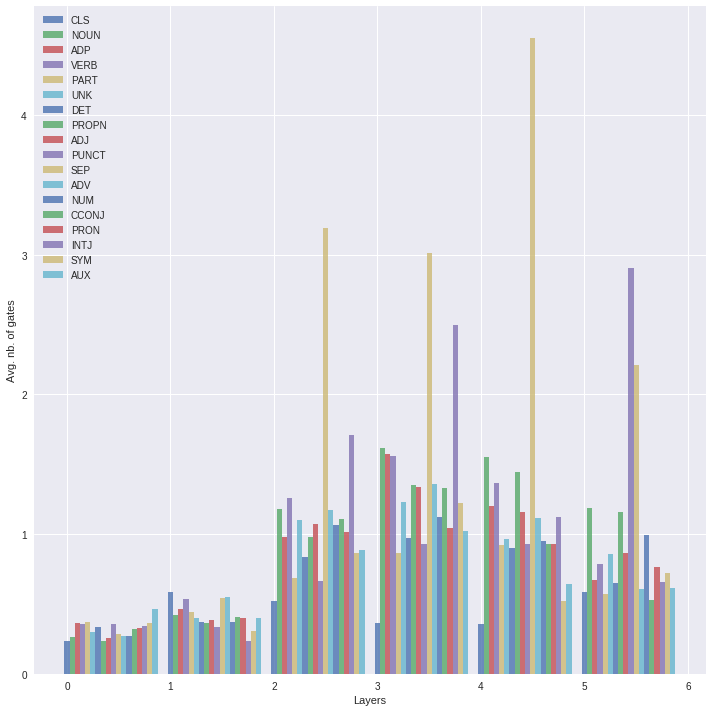

In [83]:
merge = [["PROPN", "NOUN", "ADJ"], ["ADV", "VERB"], ["ADP"], ["DET"], ["PUNCT"] ]
merge = [["PUNCT"], ["DET"], ["ADP", "CCONJ"], ["ADV", "VERB"], ["PROPN", "NOUN", "ADJ"]]

fig, ax = plt.subplots(figsize=(10, 10))
index = np.arange(6)
bar_width = 1/(len(list(count_layer)) + 2)
opacity = 0.8

for i, k in enumerate(count_layer):
    val = np.array(slice_mean(layer_mean(count_layer[k]), 2))

    plt.bar(index + bar_width * i, val, bar_width, alpha=opacity, label=k)

plt.xlabel('Layers')
plt.ylabel('Avg. nb. of gates')

#plt.xticks(index + bar_width, [ str((i+1)*2-1) + " - " + str((i+1)*2) for i in np.arange(12)])
plt.legend()

plt.tight_layout()
#plt.savefig("9.eps", method=".eps")
plt.show()

* ## Viz

In [38]:
def get_sentence_attention(n_sentence):
    def next_word(sentence, words, size_line, token, i):
        while words[i] != token:
            sentence += [ ("UNK", np.zeros((12, size_line))) ]
            i += 1
        return sentence, i + 1

    prev_line = ""
    for token, pos, dep, gates, att, line in gen_token(n_sentence):

        if prev_line != "" and prev_line != line:
            break

        if prev_line != line:
            i = 0
            sentence = []
            words = line.split(" ")
            size_line = len(words)
            prev_line = line

        sentence, i = next_word(sentence, words, size_line, token, i)
        sentence += [(token, att)]

    sentence += [("UNK", np.zeros((12, size_line)))]    

    return sentence, words, size_line

def get_sentence_layer_attention(sentence, size_line):
    mat = []
    for token, att in sentence:
        att_layer = np.array([ np.sum([ np.zeros(size_line) if not e else e for e in l_a ], 0)
                              for l_a in att ])
        mat += [att_layer]
    return np.array(mat)

def get_norm_sentence_layer(mat, normalize=True):
    res = []
    for layer in mat.transpose(1, 0, 2):
        norm = [ (e / (e.sum() if (normalize and e.sum()) else 1)) for e in layer ]
        res += [np.sum(norm, 0)]
    return np.array(res)

def get_full_norm_sentence_layer(mat, normalize=True):
    res = []
    for layer in mat.transpose(1, 0, 2):
        norm = [ (e / (e.sum() if (normalize and e.sum()) else 1)) for e in layer ]
        res += [norm]
    return np.array(res)

def plot_attended_token(res, words, scale=12):
    res = np.transpose(res).reshape(res.shape[1], scale, -1).sum(2)

    plt.figure(figsize = (15, 15))
    plt.imshow(res)

    for i, l in enumerate(words):
        plt.text(scale, i+.2, l, fontsize=20)

In [39]:
sentence, words, size_line = get_sentence_attention(n_sentence=388)

ValueError: setting an array element with a sequence.

In [62]:
[ att[0][0] for token, att in sentence[1:-1] ]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 [5.7713819842319936e-05,
  5.436301216832362e-05,
  3.942469265894033e-05,
  5.6765376939438283e-05,
  4.686877582571469e-05,
  4.886048918706365e-05,
  5.6153447076212615e-05,
  8.135339885484427e-05,
  0.00019797497952822596,
  7.72574931033887e-05,
  8.25165188871324e-05,
  5.4670730605721474e-05,
  7.189412281149998e-05,
  5.6994576880242676e-05,
  4.943257590639405e-05,
  8.39844869915396e-05,
  4.286903276806697e-05,
  5.1592211093520746e-05,
  8.37614425108768e-05,
  6.236280751181766e-05],
 0,
 0,
 0,
 0,
 [7.710082741141377e-07,
  7.581718932669901e-07,
  5.911001039748953e-07,
  9.08686217826471e-07,
  7.277995450749586e-07,
  7.505295229748299e-07,
  8.078746418505034e-07,
  1.2555226476251846e-06,
  9.960465376934735e-07,
  1.2019173709632014e-06,
  1.1214835922146449e-06,
  7.299466915355879e-07,
  1.0418530109745916e-06,
  2.640245838847477e-06,
  7.758584388284362e-07,
  1.1231649068577099e-06,
  6.184754965943284e-07,
  7.718289793956501e-07

In [48]:
mat = np.array([ np.array(att).sum(1) for _, att in sentence[1:-1] ]) 
mat = mat.transpose(1, 0, 2)
mat = mat[:,:-1,1:-2]

lay_sum = []
for layer in range(12):
    if mat[layer].sum():
        lay_sum += [ mat[layer].sum() ]
        mat[layer] /= mat[layer].max()

ValueError: setting an array element with a sequence.

In [27]:
res = mat.transpose(1, 0, 2)
res = res.reshape(-1, 12, size_line, size_line).mean(0)
res.shape

ValueError: cannot reshape array of size 3888 into shape (12,21,21)

In [ ]:
sum_attending = res.sum(0).mean(1)[1:-2]
sum_attended = res.sum(0).mean(0)[1:-2]
attended = np.zeros(res.shape)
lay_sum = []
for layer in range(len(res)):
    for token in range(len(res[layer])):
        d = np.argsort(-res[layer, token][1:-2])
        attended[layer, token][1:-2][d] = res[layer, token][1:-2][d]
    if attended[layer].sum():
        lay_sum += [ attended[layer].sum() ]
        attended[layer] /= attended[layer].max()

In [ ]:
res = get_norm_sentence_layer(mat, normalize=True)
plot_attended_token(res, words, scale=4)

In [ ]:
fig, ax = plt.subplots(figsize = (25, 15))

for layer in range(len(res)):
    dot = lay_sum[layer] * 10
    ax.scatter(layer * 1.2 + .5, 1, alpha=1, s=dot, c="royalblue", label="Unnormalized mean layer")
    for token_a in range(size_line):
        dot = attended[layer, token_a].sum() * 100
        ax.scatter((layer + 1) * 1.2 - .2, size_line - token_a, alpha=1, s=dot, c="red", label="Emitted att.")

        dot = attended[layer, :, token_a].sum() * 100
        ax.scatter(layer * 1.2, size_line - token_a, alpha=1, s=dot, c="black", label="Received att.")
        for token_b in range(size_line):
            alpha = attended[layer, token_a, token_b]
            ax.plot([layer * 1.2 + 1, layer * 1.2], [size_line - token_a, size_line - token_b],
                    'ro-', alpha=alpha, markersize=0, color="royalblue", label="Att. value")

for i in range(1, size_line - 2):
    plt.text(len(res) * 1.2 + .5, size_line - i - .2 , words[i], fontsize=20)

for layer in range(len(res)):
    plt.text(layer * 1.2 + .4, -0.2, str(layer+1), fontsize=20)

ax.scatter(0, 0, alpha=0)    
    
handles, labels = pyplot.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)

lgd = plt.legend(newHandles, newLabels, loc="upper center", prop={'size': 20}, ncol=4)
for legend_handle in lgd.legendHandles:
    legend_handle._sizes = [100]
    legend_handle.set_alpha(1)

fig.patch.set_visible(False)
ax.axis('off')

plt.tight_layout()
plt.savefig("10.pdf", method=".pdf")

plt.show()